## All stations models

In [12]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from scipy import stats
import re
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline
# %run model_utils.ipynb

In [13]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)


## Final 1

In [14]:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [15]:
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [16]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='stand'
IPython.display.clear_output()

In [18]:
train_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_train_df_{scaler_type}.csv')
test_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_test_df_{scaler_type}.csv')
val_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_val_df_{scaler_type}.csv')

In [19]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(train_df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(train_df.columns))) 

In [20]:
station = 'all'
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 250
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps

In [21]:
## read functions
%run model_utils.ipynb

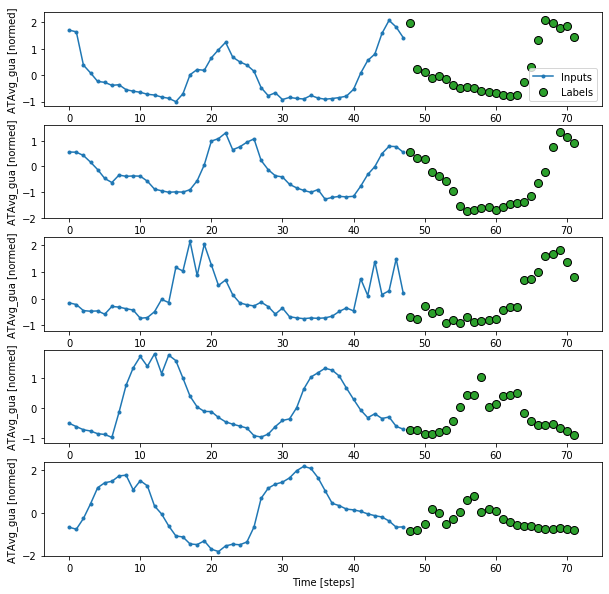

In [22]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

42/42 [==============================] - 4s 97ms/step - loss: 0.3507 - mean_absolute_error: 0.3694
CPU times: user 23min 37s, sys: 6min 26s, total: 30min 3s
Wall time: 7min


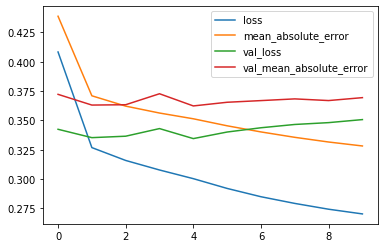

In [23]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.he_normal()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)


losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)


per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_final1performance_overall.csv')

In [24]:
%%time
accuracy={}
plot_col = vars_to_analize
scaler_type='stand'
for col in range(len(plot_col)):
    plot_col_index = window.column_indices[plot_col[col]]
    all_preds=[]
    all_labels =[]
    n_batches = len(tuple(window.test))
    for i in range(n_batches):
        #print(f'i = {i}')
        for inputs, labels in window.test.take(i):  # iterate over batches

            numpy_labels = labels.numpy() ### get labels
            numpy_inputs = inputs.numpy() ### get inputs
            preds = multi_lstm_model(numpy_inputs) ### make prediction from trined model
            numpy_preds = preds.numpy() ### get predictions

            all_preds_by_time = []
            all_labels_by_time = []
            
         
            scaler = StandardScaler()
            obj = scaler.fit(test_df_raw)

            for j in range(numpy_labels.shape[1]): ## number of time steps
                ### get values for each bacth and time and de-normalize
                #print(f'j = {j}')
                
                batch_pred = obj.inverse_transform(numpy_preds[:,j,:])[:,plot_col_index]
                batch_label = obj.inverse_transform(numpy_labels[:,j,:])[:,plot_col_index]

                all_preds_by_time.extend(batch_pred)
                #print(f'all_preds_by_time = {len(all_preds_by_time)}')
                all_labels_by_time.extend(batch_label)


            all_preds.append(all_preds_by_time)
            all_labels.append(all_labels_by_time)
            if len(all_preds) >= i:
                break

            ## covert to array (shape= i,time*batch_size)
    multi_preds = np.vstack(all_preds)
    multi_labels = np.vstack(all_labels)
    mae_pred = []
    r2_pred = []
    mse_pred =[]
    rmse_pred = []
    for a in np.arange(0,multi_labels.shape[1],step=batch_size):
        multi_labels[:,a:a+batch_size]= np.nan_to_num(multi_labels[:,a:a+batch_size],100) ## substitute NANwith 100 for RH
        multi_preds[:,a:a+batch_size]= np.nan_to_num(multi_preds[:,a:a+batch_size],100)
        
        mae = mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mae_pred.append(mae)
        mse = mean_squared_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mse_pred.append(mse)
        rmse = math.sqrt(mse)
        rmse_pred.append(rmse)
        r2 = round(r2_score(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size]),3)
        r2_pred.append(r2)
    
#         if a == 0:
#             fig, ax = plt.subplots(1, 4, figsize=(20, 5))
#             #plt.suptitle(f'{multi_lstm_model}, window: {window.input_width}_{window.shift}',fontsize = 14)
#             ax[0].plot(df.index, df.mae, '-o',c='#ff5555')
#             ax[0].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[0].set_ylabel(f'MAE {plot_col[col]} [de-normed]')
#             ax[3].plot(df.index, df.r2,'-o', c='#0ca4b4')
#             ax[3].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[3].set_ylabel(f'R2 {plot_col[col]} [de-normed]')
#             ax[1].plot(df.index, df.mse,'-o', c='#ff5555')
#             ax[1].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[1].set_ylabel(f'MSE {plot_col[col]} [de-normed]')
#             ax[2].plot(df.index, df.rmse, '-o',c='#ff5555')
#             ax[2].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[2].set_ylabel(f'RMSE {plot_col[col]} [de-normed]')
    
    
    df = pd.DataFrame(mae_pred, columns=['mae'])
    df['r2']=r2_pred
    df['mse']=mse_pred
    df['rmse']=rmse_pred
    accuracy[plot_col[col]] = {'r2':r2_pred,
                               'mae':mae_pred,
                               'mse': mse_pred,
                               'rmse':rmse_pred}

    
r2 ={}
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_final1performance_times.csv')

CPU times: user 9min 46s, sys: 3min 23s, total: 13min 9s
Wall time: 3min 36s


## Final 2

In [25]:
## read functions
%run model_utils.ipynb

In [26]:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [27]:
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [28]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='stand'
IPython.display.clear_output()

In [30]:
train_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_train_df_{scaler_type}.csv')
test_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_test_df_{scaler_type}.csv')
val_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_val_df_{scaler_type}.csv')

In [31]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(train_df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(train_df.columns))) 

In [32]:
station = 'all'
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 250
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps

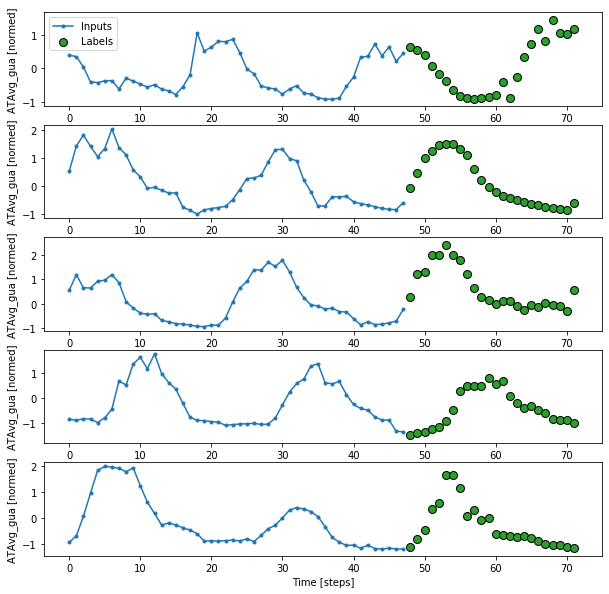

In [33]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

42/42 [==============================] - 4s 89ms/step - loss: 0.3475 - mean_absolute_error: 0.3656
CPU times: user 19min 5s, sys: 5min 11s, total: 24min 17s
Wall time: 5min 44s


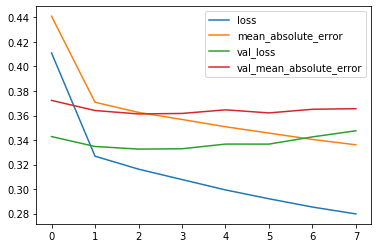

In [34]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.he_normal()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)


losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)


per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_final2performance_overall.csv')

In [35]:
%%time
accuracy={}
plot_col = vars_to_analize
scaler_type='stand'
for col in range(len(plot_col)):
    plot_col_index = window.column_indices[plot_col[col]]
    all_preds=[]
    all_labels =[]
    n_batches = len(tuple(window.test))
    for i in range(n_batches):
        #print(f'i = {i}')
        for inputs, labels in window.test.take(i):  # iterate over batches

            numpy_labels = labels.numpy() ### get labels
            numpy_inputs = inputs.numpy() ### get inputs
            preds = multi_lstm_model(numpy_inputs) ### make prediction from trined model
            numpy_preds = preds.numpy() ### get predictions

            all_preds_by_time = []
            all_labels_by_time = []
            
         
            scaler = StandardScaler()
            obj = scaler.fit(test_df_raw)

            for j in range(numpy_labels.shape[1]): ## number of time steps
                ### get values for each bacth and time and de-normalize
                #print(f'j = {j}')
                
                batch_pred = obj.inverse_transform(numpy_preds[:,j,:])[:,plot_col_index]
                batch_label = obj.inverse_transform(numpy_labels[:,j,:])[:,plot_col_index]

                all_preds_by_time.extend(batch_pred)
                #print(f'all_preds_by_time = {len(all_preds_by_time)}')
                all_labels_by_time.extend(batch_label)


            all_preds.append(all_preds_by_time)
            all_labels.append(all_labels_by_time)
            if len(all_preds) >= i:
                break

            ## covert to array (shape= i,time*batch_size)
    multi_preds = np.vstack(all_preds)
    multi_labels = np.vstack(all_labels)
    mae_pred = []
    r2_pred = []
    mse_pred =[]
    rmse_pred = []
    for a in np.arange(0,multi_labels.shape[1],step=batch_size):
        multi_labels[:,a:a+batch_size]= np.nan_to_num(multi_labels[:,a:a+batch_size],100) ## substitute NANwith 100 for RH
        multi_preds[:,a:a+batch_size]= np.nan_to_num(multi_preds[:,a:a+batch_size],100)
        
        mae = mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mae_pred.append(mae)
        mse = mean_squared_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mse_pred.append(mse)
        rmse = math.sqrt(mse)
        rmse_pred.append(rmse)
        r2 = round(r2_score(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size]),3)
        r2_pred.append(r2)
    
#         if a == 0:
#             fig, ax = plt.subplots(1, 4, figsize=(20, 5))
#             #plt.suptitle(f'{multi_lstm_model}, window: {window.input_width}_{window.shift}',fontsize = 14)
#             ax[0].plot(df.index, df.mae, '-o',c='#ff5555')
#             ax[0].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[0].set_ylabel(f'MAE {plot_col[col]} [de-normed]')
#             ax[3].plot(df.index, df.r2,'-o', c='#0ca4b4')
#             ax[3].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[3].set_ylabel(f'R2 {plot_col[col]} [de-normed]')
#             ax[1].plot(df.index, df.mse,'-o', c='#ff5555')
#             ax[1].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[1].set_ylabel(f'MSE {plot_col[col]} [de-normed]')
#             ax[2].plot(df.index, df.rmse, '-o',c='#ff5555')
#             ax[2].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[2].set_ylabel(f'RMSE {plot_col[col]} [de-normed]')
    
    
    df = pd.DataFrame(mae_pred, columns=['mae'])
    df['r2']=r2_pred
    df['mse']=mse_pred
    df['rmse']=rmse_pred
    accuracy[plot_col[col]] = {'r2':r2_pred,
                               'mae':mae_pred,
                               'mse': mse_pred,
                               'rmse':rmse_pred}

    
r2 ={}
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_final2performance_times.csv')

CPU times: user 9min 50s, sys: 3min 23s, total: 13min 14s
Wall time: 3min 38s


## Final 3

In [36]:
## read functions
%run model_utils.ipynb

In [37]:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [38]:
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [39]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='stand'
IPython.display.clear_output()

In [41]:
train_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_train_df_{scaler_type}.csv')
test_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_test_df_{scaler_type}.csv')
val_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_val_df_{scaler_type}.csv')

In [42]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(train_df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(train_df.columns))) 

In [43]:
station = 'all'
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 250
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps

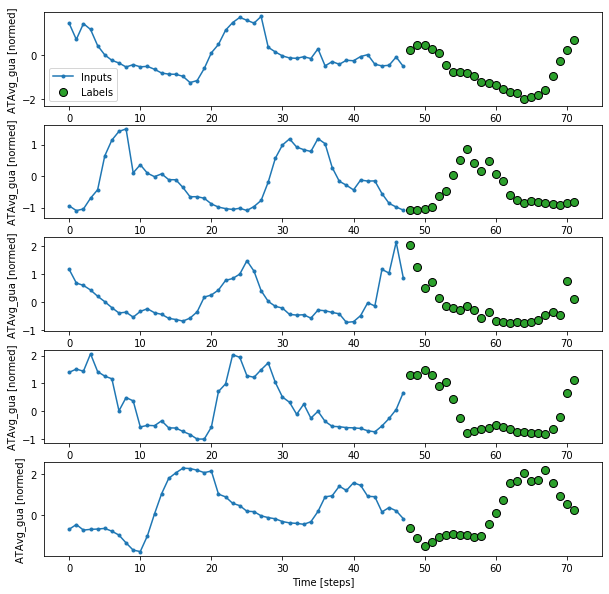

In [44]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

42/42 [==============================] - 4s 86ms/step - loss: 0.3483 - mean_absolute_error: 0.3675
CPU times: user 19min 23s, sys: 5min 17s, total: 24min 41s
Wall time: 5min 34s


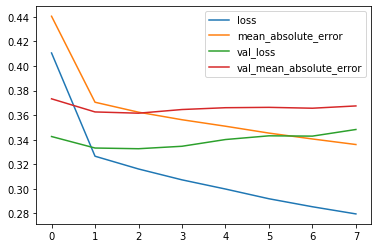

In [45]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.he_normal()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)


losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)


per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_final3performance_overall.csv')

In [46]:
%%time
accuracy={}
plot_col = vars_to_analize
scaler_type='stand'
for col in range(len(plot_col)):
    plot_col_index = window.column_indices[plot_col[col]]
    all_preds=[]
    all_labels =[]
    n_batches = len(tuple(window.test))
    for i in range(n_batches):
        #print(f'i = {i}')
        for inputs, labels in window.test.take(i):  # iterate over batches

            numpy_labels = labels.numpy() ### get labels
            numpy_inputs = inputs.numpy() ### get inputs
            preds = multi_lstm_model(numpy_inputs) ### make prediction from trined model
            numpy_preds = preds.numpy() ### get predictions

            all_preds_by_time = []
            all_labels_by_time = []
            
         
            scaler = StandardScaler()
            obj = scaler.fit(test_df_raw)

            for j in range(numpy_labels.shape[1]): ## number of time steps
                ### get values for each bacth and time and de-normalize
                #print(f'j = {j}')
                
                batch_pred = obj.inverse_transform(numpy_preds[:,j,:])[:,plot_col_index]
                batch_label = obj.inverse_transform(numpy_labels[:,j,:])[:,plot_col_index]

                all_preds_by_time.extend(batch_pred)
                #print(f'all_preds_by_time = {len(all_preds_by_time)}')
                all_labels_by_time.extend(batch_label)


            all_preds.append(all_preds_by_time)
            all_labels.append(all_labels_by_time)
            if len(all_preds) >= i:
                break

            ## covert to array (shape= i,time*batch_size)
    multi_preds = np.vstack(all_preds)
    multi_labels = np.vstack(all_labels)
    mae_pred = []
    r2_pred = []
    mse_pred =[]
    rmse_pred = []
    for a in np.arange(0,multi_labels.shape[1],step=batch_size):
        multi_labels[:,a:a+batch_size]= np.nan_to_num(multi_labels[:,a:a+batch_size],100) ## substitute NANwith 100 for RH
        multi_preds[:,a:a+batch_size]= np.nan_to_num(multi_preds[:,a:a+batch_size],100)
        
        mae = mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mae_pred.append(mae)
        mse = mean_squared_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mse_pred.append(mse)
        rmse = math.sqrt(mse)
        rmse_pred.append(rmse)
        r2 = round(r2_score(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size]),3)
        r2_pred.append(r2)
    
#         if a == 0:
#             fig, ax = plt.subplots(1, 4, figsize=(20, 5))
#             #plt.suptitle(f'{multi_lstm_model}, window: {window.input_width}_{window.shift}',fontsize = 14)
#             ax[0].plot(df.index, df.mae, '-o',c='#ff5555')
#             ax[0].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[0].set_ylabel(f'MAE {plot_col[col]} [de-normed]')
#             ax[3].plot(df.index, df.r2,'-o', c='#0ca4b4')
#             ax[3].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[3].set_ylabel(f'R2 {plot_col[col]} [de-normed]')
#             ax[1].plot(df.index, df.mse,'-o', c='#ff5555')
#             ax[1].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[1].set_ylabel(f'MSE {plot_col[col]} [de-normed]')
#             ax[2].plot(df.index, df.rmse, '-o',c='#ff5555')
#             ax[2].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[2].set_ylabel(f'RMSE {plot_col[col]} [de-normed]')
    
    
    df = pd.DataFrame(mae_pred, columns=['mae'])
    df['r2']=r2_pred
    df['mse']=mse_pred
    df['rmse']=rmse_pred
    accuracy[plot_col[col]] = {'r2':r2_pred,
                               'mae':mae_pred,
                               'mse': mse_pred,
                               'rmse':rmse_pred}

    
r2 ={}
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_final3performance_times.csv')

CPU times: user 9min 51s, sys: 3min 25s, total: 13min 17s
Wall time: 3min 36s
